In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
%pip install tensorflow

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install scikit-learn pandas matplotlib opencv-python tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.1 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 37.9 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 113 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 19.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 

In [14]:
import os, glob
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

data_dir = "/Users/srabontideb/Downloads/Young Learner_s Research Lab/GAN/kvasir_bilateral_filtered"

image_paths = []
labels = []

# Get class folders
class_names = sorted(os.listdir(data_dir))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for cls_name in class_names:
    cls_folder = os.path.join(data_dir, cls_name)
    for img_path in glob.glob(os.path.join(cls_folder, '*.*')):
        image_paths.append(img_path)
        labels.append(class_to_idx[cls_name])

image_paths, labels = shuffle(image_paths, labels, random_state=42)
X = np.array(image_paths)
y = np.array(labels)

print(f"Total images: {len(X)}; Classes: {class_names}")


Total images: 8000; Classes: ['00', '01', '02', '03', '04', '05', '06', '07']


In [16]:
# ============================
# 1) Train/Val/Test split (stratified)
# ============================
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np, pandas as pd, time, os
from pathlib import Path

RANDOM_STATE = 42
TEST_SIZE    = 0.20      # <- change if you want (e.g., 0.1 or 0.15)
N_SPLITS     = 5         # k for CV

# X = np.array(image_paths); y = np.array(labels)  # <- you already have these

# Hold out the test set FIRST (never touched during CV/early stopping)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Safety checks (no overlap)
assert set(X_trainval).isdisjoint(set(X_test)), "Leak: train/val and test overlap!"
assert len(X_trainval) + len(X_test) == len(X)

print(f"Train+Val: {len(X_trainval)}   Test: {len(X_test)}")

# ============================
# 2) Stratified K-Fold on TRAIN+VAL ONLY
# ============================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

folds_data = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval), start=1):
    folds_data.append({
        "fold": fold,
        "train_paths": X_trainval[tr_idx],
        "train_labels": y_trainval[tr_idx],
        "val_paths":   X_trainval[val_idx],
        "val_labels":  y_trainval[val_idx],
    })
    print(f"Fold {fold}: train={len(tr_idx)}, val={len(val_idx)}")

# ============================
# 3) Save splits for reuse (Quick Save will capture these)
# ============================
OUT = Path("/Users/srabontideb/Downloads/Young Learner_s Research Lab/GAN/kvasir_bilateral_filtered/output")/f"splits_{time.strftime('%Y%m%d_%H%M')}"
OUT.mkdir(parents=True, exist_ok=True)

# Test set (held-out)
pd.DataFrame({"filepath": X_test, "label": y_test}).to_csv(OUT/"test.csv", index=False)

# Train/Val folds
pd.DataFrame({"filepath": X_trainval, "label": y_trainval}).to_csv(OUT/"trainval.csv", index=False)
for f in folds_data:
    fold = f["fold"]
    pd.DataFrame({"filepath": f["train_paths"], "label": f["train_labels"]}).to_csv(OUT/f"train_fold{fold}.csv", index=False)
    pd.DataFrame({"filepath": f["val_paths"],   "label": f["val_labels"]}).to_csv(OUT/f"val_fold{fold}.csv",   index=False)

print("Saved splits to:", OUT)


Train+Val: 6400   Test: 1600
Fold 1: train=5120, val=1280
Fold 2: train=5120, val=1280
Fold 3: train=5120, val=1280
Fold 4: train=5120, val=1280
Fold 5: train=5120, val=1280
Saved splits to: /Users/srabontideb/Downloads/Young Learner_s Research Lab/GAN/kvasir_bilateral_filtered/output/splits_20251013_1039


In [17]:
print(tf.config.list_physical_devices('GPU'))


[]


In [19]:
import tensorflow as tf

IMG_SIZE = (224, 224)  # adjust as needed
BATCH_SIZE = 32

def decode_img(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # or decode_png if png
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_tf_dataset(file_paths, labels, batch_size=BATCH_SIZE, shuffle_data=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle_data:
        ds = ds.shuffle(buffer_size=len(file_paths))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [21]:
# =========================
# 0) Imports
# =========================
import os, math, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.mixed_precision import set_global_policy

# Optional: mixed precision for speed on P100 (usually beneficial)
set_global_policy("mixed_float16")

# Keras ConvNeXt (requires TF/Keras >= 2.11)
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# =========================
# 1) Config
# =========================
IMG_SIZE = (224, 224)         # ConvNeXt default
BATCH_SIZE = 32
EPOCHS_WARMUP = 3             # freeze backbone first
EPOCHS_FINETUNE = 12          # then unfreeze
LR_WARMUP = 1e-3
LR_FINETUNE = 5e-4
AUTOTUNE = tf.data.AUTOTUNE
N_FOLDS = len(folds_data)     # should be 5 for your setup
N_CLASSES = len(class_names)

# =========================
# 2) Data pipeline
#    (ConvNeXt expects its own preprocessing; we keep images in [0..255] float and apply convnext_preprocess)
# =========================
def decode_img_for_convnext(file_path, label):
    img = tf.io.read_file(file_path)
    # change decode_* if your files are PNG
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # keep as float32 in [0..255] for convnext_preprocess
    img = tf.cast(img, tf.float32)
    return img, label

# Light on-the-fly augmentation (you can tune as needed)
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="augment")

@tf.function
def apply_preprocess(x, y):
    # ConvNeXt preprocess: channel-wise normalize to ImageNet statistics internally
    x = convnext_preprocess(x)   # returns float32
    return x, y

def make_tf_dataset_convnext(file_paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.shuffle(len(file_paths), reshuffle_each_iteration=True) if training else ds
    ds = ds.map(decode_img_for_convnext, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# =========================
# 3) ConvNeXt-Tiny model builder
# =========================
def build_convnext_tiny(num_classes=N_CLASSES, image_size=IMG_SIZE, trainable_backbone=False):
    # Backbone
    backbone = ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling=None
    )
    backbone.trainable = trainable_backbone  # warmup: False; finetune: True

    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    # NOTE: we already applied convnext_preprocess in the dataset, so we pass inputs directly.
    x = backbone(inputs, training=False)

    # Head (recommend GAP + BN + dropout + Dense)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    # Final classifier
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # force float32 for numeric stability

    model = models.Model(inputs, outputs, name="ConvNeXtTiny_Kvasir")
    return model

# =========================
# 4) Training utilities
# =========================
def compile_model(model, lr):
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy(name="acc")]
    )

def get_callbacks(fold_id):
    os.makedirs("convnext_runs", exist_ok=True)
    return [
        EarlyStopping(monitor="val_acc", patience=6, mode="max", restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        ModelCheckpoint(
            filepath=f"convnext_runs/best_convnextT_fold{fold_id}.h5",
            monitor="val_acc", mode="max", save_best_only=True, verbose=1
        ),
        CSVLogger(f"convnext_runs/training_log_fold{fold_id}.csv", append=False)
    ]

# =========================
# 5) 5-Fold training (warmup + finetune)
# =========================
fold_metrics = []

for fold_id in range(N_FOLDS):
    print(f"\n================= FOLD {fold_id+1}/{N_FOLDS} =================")

    # Build datasets
    train_paths = folds_data[fold_id]['train_paths']
    train_labels = folds_data[fold_id]['train_labels']
    val_paths   = folds_data[fold_id]['val_paths']
    val_labels  = folds_data[fold_id]['val_labels']

    train_ds = make_tf_dataset_convnext(train_paths, train_labels, training=True)
    val_ds   = make_tf_dataset_convnext(val_paths,   val_labels,   training=False)

    # 5.1 Warmup: freeze backbone
    model = build_convnext_tiny(trainable_backbone=False)
    compile_model(model, lr=LR_WARMUP)
    cb = get_callbacks(fold_id)

    print("\n---- Warmup (frozen backbone) ----")
    history_warmup = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_WARMUP,
        callbacks=cb,
        verbose=1
    )

    # 5.2 Fine-tune: unfreeze backbone
    model.get_layer(index=1).trainable = True  # backbone is the 2nd layer (index 1)
    # (Optional) fine-tune last N blocks only:
    # for l in model.get_layer(index=1).layers[:-20]:  # keep last ~20 layers trainable
    #     l.trainable = False

    compile_model(model, lr=LR_FINETUNE)
    print("\n---- Fine-tuning (unfrozen backbone) ----")
    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINETUNE,
        callbacks=cb,
        verbose=1
    )

    # Evaluate best weights
    eval_res = model.evaluate(val_ds, verbose=0)
    # eval_res -> [loss, acc]
    fold_metrics.append({"fold": fold_id+1, "val_loss": float(eval_res[0]), "val_acc": float(eval_res[1])})
    print(f"FOLD {fold_id+1} → val_loss: {eval_res[0]:.4f} | val_acc: {eval_res[1]:.4f}")

# =========================
# 6) Summary across folds
# =========================
val_accs  = [m["val_acc"]  for m in fold_metrics]
val_losses= [m["val_loss"] for m in fold_metrics]

print("\n========= 5-Fold Summary (ConvNeXt-T) =========")
for m in fold_metrics:
    print(f"Fold {m['fold']}:  val_acc={m['val_acc']:.4f},  val_loss={m['val_loss']:.4f}")

print(f"\nMean val_acc: {np.mean(val_accs):.4f}  (± {np.std(val_accs):.4f})")
print(f"Mean val_loss: {np.mean(val_losses):.4f} (± {np.std(val_losses):.4f})")



================= FOLD 1/5 =================
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

---- Warmup (frozen backbone) ----
Epoch 1/3


I0000 00:00:1760330391.633763 1930040 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 31/160 ━━━━━━━━━━━━━━━━━━━━ 12:09 6s/step - acc: 0.2163 - loss: 2.5576

KeyboardInterrupt: 

Matplotlib is building the font cache; this may take a moment.


[skip] /kaggle/working/convnext_runs/training_log_fold0.csv not found
[skip] /kaggle/working/convnext_runs/training_log_fold1.csv not found
[skip] /kaggle/working/convnext_runs/training_log_fold2.csv not found
[skip] /kaggle/working/convnext_runs/training_log_fold3.csv not found
[skip] /kaggle/working/convnext_runs/training_log_fold4.csv not found


/var/folders/b1/f_5mk66d2773tzpl944mshqw0000gn/T/ipykernel_28039/1383662929.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title("Validation Accuracy — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.grid(True, linewidth=0.3); plt.legend()


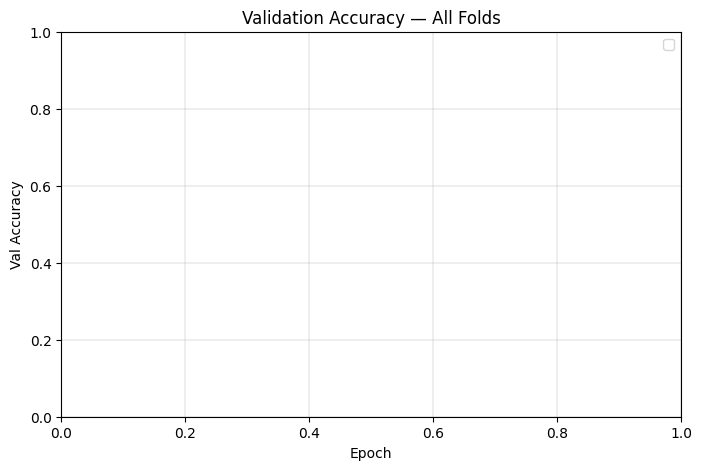

/var/folders/b1/f_5mk66d2773tzpl944mshqw0000gn/T/ipykernel_28039/1383662929.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title("Validation Loss — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.grid(True, linewidth=0.3); plt.legend()


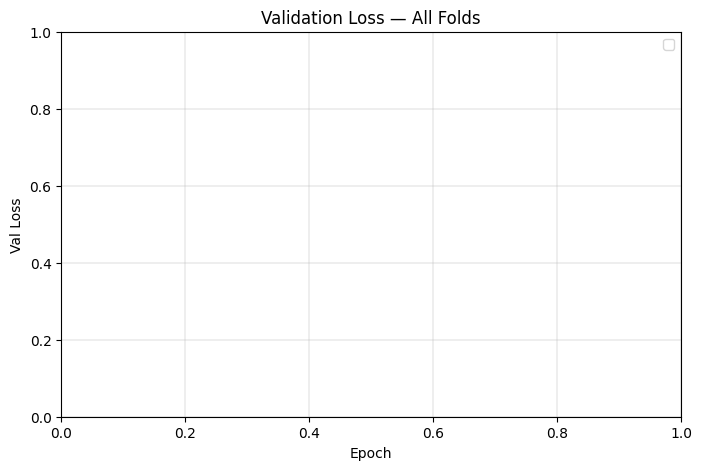

In [22]:
# Inline visualization of training/validation curves from CSVLogger outputs
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

LOG_DIR = Path("/kaggle/working/convnext_runs")
N_FOLDS = 5  # change if needed

def pick_cols(df):
    m = {c.lower().strip(): c for c in df.columns}
    acc = m.get("acc") or m.get("accuracy") or m.get("sparse_categorical_accuracy") or m.get("categorical_accuracy")
    val_acc = m.get("val_acc") or m.get("val_accuracy") or m.get("val_sparse_categorical_accuracy") or m.get("val_categorical_accuracy")
    loss = m.get("loss")
    val_loss = m.get("val_loss")
    return acc, val_acc, loss, val_loss

# --- Per-fold panels ---
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists():
        print(f"[skip] {csvp} not found"); 
        continue
    df = pd.read_csv(csvp)
    acc, val_acc, loss, val_loss = pick_cols(df)
    epochs = np.arange(1, len(df)+1)

    # Accuracy
    plt.figure(figsize=(7,4))
    if acc:     plt.plot(epochs, df[acc], label="train acc")
    if val_acc: plt.plot(epochs, df[val_acc], label="val acc")
    plt.title(f"Fold {f} • Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True, linewidth=0.3); plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(7,4))
    if loss:     plt.plot(epochs, df[loss], label="train loss")
    if val_loss: plt.plot(epochs, df[val_loss], label="val loss")
    plt.title(f"Fold {f} • Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, linewidth=0.3); plt.legend()
    plt.show()

# --- All-folds comparison (validation curves only) ---
plt.figure(figsize=(8,5))
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists(): continue
    df = pd.read_csv(csvp)
    _, val_acc, _, val_loss = pick_cols(df)
    if val_acc: plt.plot(np.arange(1, len(df)+1), df[val_acc], label=f"Fold {f}")
plt.title("Validation Accuracy — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.grid(True, linewidth=0.3); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists(): continue
    df = pd.read_csv(csvp)
    _, _, _, val_loss = pick_cols(df)
    if val_loss: plt.plot(np.arange(1, len(df)+1), df[val_loss], label=f"Fold {f}")
plt.title("Validation Loss — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.grid(True, linewidth=0.3); plt.legend()
plt.show()


In [24]:
# =============== Robust Grad-CAM (manual forward; heatmap only) ===============
import os, glob, random, numpy as np, tensorflow as tf, cv2
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# --- CONFIG ---
DATA_ROOT = "/kaggle/input/kvasir-final-preprocessed-data/kvasir_bilateral_filtered"
WEIGHTS   = Path("/kaggle/working/convnext_runs/best_convnextT_fold4.h5")  # change fold if you want
IMG_SIZE  = (224, 224)
N_CLASSES = 8
TARGET    = "pred"  # "pred" or an int class id
OUT_DIR   = Path("/Users/srabontideb/Downloads/Young Learner_s Research Lab/GAN/kvasir_bilateral_filtered/output"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Build SAME head you trained and load weights ---
def build_model(nc=N_CLASSES, image_size=IMG_SIZE):
    bb = ConvNeXtTiny(include_top=False, weights=None,
                      input_shape=(image_size[0], image_size[1], 3), pooling=None)
    inp = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = bb(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(nc, activation="softmax", dtype="float32")(x)
    return models.Model(inp, out)

model = build_model()
model.load_weights(str(WEIGHTS))

# --- Pick a real image (or set IMG_PATH yourself) ---
def pick_image(root):
    exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.PNG","*.JPEG")
    c = []
    for e in exts: c += glob.glob(os.path.join(root, "**", e), recursive=True)
    assert c, f"No images under {root}"
    return random.choice(c)

IMG_PATH = pick_image(DATA_ROOT)
print("Using image:", IMG_PATH)

# --- Preprocess ---
def load_for_model(fp, size):
    img = tf.io.read_file(fp)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size)
    x = tf.cast(img, tf.float32)          # [0..255]
    x = convnext_preprocess(x)            # ConvNeXt preprocessing
    return tf.expand_dims(x, 0), tf.cast(img, tf.uint8)

x, img_uint8 = load_for_model(IMG_PATH, IMG_SIZE)

# --- Helpers ---
def find_last_4d_layer_name(m):
    # walk from end to start to get the deepest 4D (HWC) tensor layer
    for lyr in reversed(m.layers):
        shp = getattr(lyr, "output_shape", None)
        if isinstance(shp, tuple) and len(shp) == 4:
            return lyr.name
    raise ValueError("No 4D conv feature layer found for Grad-CAM.")

LAST_NAME = find_last_4d_layer_name(model)

def gradcam_manual(m, x, class_idx, last_name, img_size):
    """
    Manual forward through layers inside one GradientTape to avoid Keras-3 multi-output issues.
    """
    with tf.GradientTape() as tape:
        t = x
        conv_out = None
        for lyr in m.layers[1:]:  # skip InputLayer at index 0
            t = lyr(t, training=False)
            if lyr.name == last_name:
                conv_out = t
        preds = t                            # (1, C)
        target = preds[:, class_idx]         # scalar per sample
    assert conv_out is not None, "Last conv feature not found during forward pass."
    grads   = tape.gradient(target, conv_out)          # (1, h, w, C)
    weights = tf.reduce_mean(grads, axis=(0,1,2))      # (C,)
    cam     = tf.tensordot(conv_out[0], weights, axes=1)  # (h, w)
    cam     = tf.nn.relu(cam)
    cam     = cam / (tf.reduce_max(cam) + 1e-12)
    cam     = tf.image.resize(cam[...,None], img_size)[...,0]
    return cam.numpy(), preds.numpy()[0]

# --- First pass to get predicted class (then CAM for it) ---
cam_tmp, probs0 = gradcam_manual(model, x, class_idx=0, last_name=LAST_NAME, img_size=IMG_SIZE)
pred_id = int(np.argmax(probs0))
class_idx = pred_id if TARGET == "pred" else int(TARGET)

# --- Final CAM for chosen class ---
cam, probs = gradcam_manual(model, x, class_idx=class_idx, last_name=LAST_NAME, img_size=IMG_SIZE)

# --- Save grayscale heatmap ---
out_path = OUT_DIR / f"cam_{Path(IMG_PATH).stem}_class{class_idx}.png"
cv2.imwrite(str(out_path), (np.clip(cam,0,1)*255).astype(np.uint8))
print(f"Saved heatmap → {out_path}")
print("Predicted class id:", pred_id, "| CAM for class id:", class_idx)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/convnext_runs/best_convnextT_fold4.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [25]:
# Phase 5: PostSegXAI — setup
import os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Save dirs
FOLD_ID = 4           # <-- choose the fold you want to inspect
OUT_DIR = f"postsegxai_fold{FOLD_ID}"
os.makedirs(OUT_DIR, exist_ok=True)

# Convenience
N_CLASSES = len(class_names)
print("Classes:", class_names)
print("Fold:", FOLD_ID)


Classes: ['00', '01', '02', '03', '04', '05', '06', '07']
Fold: 4


In [26]:
# If build_convnext_tiny & convnext_preprocess are not in scope, re-import:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from tensorflow.keras import layers, models

def build_convnext_tiny(num_classes=N_CLASSES, image_size=IMG_SIZE, trainable_backbone=True):
    backbone = ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling=None
    )
    backbone.trainable = trainable_backbone
    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = backbone(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return models.Model(inputs, outputs, name="ConvNeXtTiny_Kvasir")

# Rebuild + load weights from training (works even if .h5 full-model load fails)
model = build_convnext_tiny()
model.load_weights(f"convnext_runs/best_convnextT_fold{FOLD_ID}.h5")
print("Model rebuilt + weights loaded.")
model.summary()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'convnext_runs/best_convnextT_fold4.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
# Paths for this fold
val_paths = folds_data[FOLD_ID]['val_paths']
val_labels = folds_data[FOLD_ID]['val_labels']

def load_img_for_convnext(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)    # change to decode_png if needed
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)                 # [0..255]
    return img

def predict_softmax(img_raw):
    x = convnext_preprocess(img_raw[None, ...])    # preprocess inside
    p = model(x, training=False).numpy()[0]        # (C,)
    pred = int(np.argmax(p))
    conf = float(np.max(p))
    # uncertainty via entropy (nats)
    entropy = float(-np.sum(p * np.log(p + 1e-12)))
    return pred, conf, entropy, p


In [ ]:
# Find last 4D feature layer automatically (should be 'convnext_tiny')
def get_last_4d_layer(m):
    for lyr in reversed(m.layers):
        try:
            shp = lyr.output_shape
        except:
            continue
        if isinstance(shp, tuple) and len(shp) == 4:
            return lyr.name
    return m.layers[1].name  # fallback

LAST_FEAT = get_last_4d_layer(model)
print("Grad-CAM feature layer:", LAST_FEAT)

@tf.function
def _gradcam_core(img_batch, target_idx, feat_model, head_model):
    with tf.GradientTape() as tape:
        feats = feat_model(img_batch)                       # (B,h,w,c)
        tape.watch(feats)
        logits = head_model(feats, training=False)          # (B,C)
        cls = logits[:, target_idx]
    grads = tape.gradient(cls, feats)                       # (B,h,w,c)
    w = tf.reduce_mean(grads, axis=(1,2), keepdims=True)    # (B,1,1,c)
    cam = tf.nn.relu(tf.reduce_sum(w * feats, axis=-1))     # (B,h,w)
    # normalize per-image
    cam_min = tf.reduce_min(cam, axis=(1,2), keepdims=True)
    cam_max = tf.reduce_max(cam, axis=(1,2), keepdims=True)
    cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
    return cam

# Split model into feature extractor + head (after LAST_FEAT)
def split_feature_and_head(m, last_feat_name=LAST_FEAT):
    feat_layer = m.get_layer(last_feat_name)
    feat_model = tf.keras.Model(m.input, feat_layer.output)              # input -> conv feat
    # build head: from conv feat to logits, reusing layers after feat layer
    idx = [i for (i, l) in enumerate(m.layers) if l.name == last_feat_name][0]
    x = tf.keras.Input(shape=feat_layer.output_shape[1:])
    y = x
    for lyr in m.layers[idx+1:]:
        y = lyr(y)
    head_model = tf.keras.Model(x, y)
    return feat_model, head_model

feat_model, head_model = split_feature_and_head(model, LAST_FEAT)

def gradcam_heatmap(img_raw, target_idx):
    x = convnext_preprocess(img_raw[None, ...])
    cam_small = _gradcam_core(x, tf.constant(target_idx, tf.int32), feat_model, head_model)[0] # (h,w)
    cam = tf.image.resize(cam_small[..., None], IMG_SIZE)[...,0].numpy()
    return np.clip(cam, 0, 1)

def overlay_heatmap(img_raw, cam, alpha=0.45):
    img = (img_raw.numpy() / 255.0)
    cmap = plt.get_cmap('jet')
    heat = cmap(cam)[..., :3]
    out = (1 - alpha) * img + alpha * heat
    return np.clip(out, 0, 1)


In [28]:
# Backbone (ConvNeXt) as feature extractor
backbone = model.get_layer("convnext_tiny")

x_in = tf.keras.Input(shape=(224, 224, 3))     # plain input tensor
feat_out = backbone(x_in)                      # (None, 7, 7, 768)
feat_model = tf.keras.Model(x_in, feat_out, name="feat_model")

# Head model: GAP -> BN -> Dropout -> Dense
f_in = tf.keras.Input(shape=backbone.output.shape[1:])  # (7, 7, 768)
gap  = model.get_layer("global_average_pooling2d_8")(f_in)
bn   = model.get_layer("batch_normalization_8")(gap)
drop = model.get_layer("dropout_8")(bn)
out  = model.get_layer("dense_8")(drop)
head_model = tf.keras.Model(f_in, out, name="head_model")

print("✅ Rebuilt feat_model and head_model with fresh inputs")


ValueError: No such layer: global_average_pooling2d_8. Existing layers are: ['input_layer_18', 'convnext_tiny', 'global_average_pooling2d_2', 'batch_normalization_2', 'dropout_2', 'dense_2'].

In [30]:
def _gradcam_core(img_batch, target_idx, feat_model, head_model):
    with tf.GradientTape() as tape:
        feats = feat_model(img_batch, training=False)   # (B, 7, 7, 768)
        tape.watch(feats)
        logits = head_model(feats, training=False)      # (B, num_classes)
        loss = logits[:, target_idx]

    grads = tape.gradient(loss, feats)                  # (B,7,7,768)
    pooled = tf.reduce_mean(grads, axis=(1,2), keepdims=True)
    cam = tf.reduce_sum(feats * pooled, axis=-1)        # (B,7,7)
    return cam


In [31]:
def gradcam_heatmap(img_raw, target_idx):
    x = convnext_preprocess(img_raw[None, ...])   # preprocess like training
    cam_small = _gradcam_core(x, target_idx, feat_model, head_model)[0]
    cam = tf.image.resize(cam_small[..., None], IMG_SIZE)[..., 0].numpy()
    return np.maximum(cam, 0) / (cam.max() + 1e-8)   # normalize


In [32]:
def overlay_heatmap(img_raw, cam, alpha=0.4):
    heatmap = plt.cm.jet(cam)[..., :3] * 255.0
    overlay = (1 - alpha) * img_raw + alpha * heatmap
    return np.clip(overlay, 0, 255).astype("uint8")


In [33]:
# Predict entire validation fold
y_true, y_pred = [], []
y_prob = np.zeros((len(val_paths), N_CLASSES), dtype=np.float32)

for i, path in enumerate(val_paths):
    img_raw = load_img_for_convnext(path)
    pred, conf, ent, p = predict_softmax(img_raw)
    y_true.append(val_labels[i])
    y_pred.append(pred)
    y_prob[i] = p

y_true = np.array(y_true, int)
y_pred = np.array(y_pred, int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
plt.figure(figsize=(6,5))
plt.imshow(cm_norm, vmin=0, vmax=1,cmap="viridis")
plt.title("Normalized Confusion Matrix (Val)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha='right')
plt.yticks(range(N_CLASSES), class_names)
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', fontsize=8, color='white' if cm_norm[i,j]>0.5 else 'black')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=140)
plt.show()

# Classification report (per-class precision/recall/F1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


KeyboardInterrupt: 

In [34]:
# Binarize labels for ROC
Y_true_bin = label_binarize(y_true, classes=list(range(N_CLASSES)))  # shape (N, C)

fpr, tpr, roc_auc = {}, {}, {}
for c in range(N_CLASSES):
    fpr[c], tpr[c], _ = roc_curve(Y_true_bin[:, c], y_prob[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

# Micro/macro
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[c] for c in range(N_CLASSES)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(N_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= N_CLASSES
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6,5))
for c in range(N_CLASSES):
    plt.plot(fpr[c], tpr[c], lw=1, label=f"{class_names[c]} (AUC={roc_auc[c]:.3f})")
plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f"micro (AUC={roc_auc['micro']:.3f})", linestyle='--')
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Val)")
plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_curves.png"), dpi=140)
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [219, 1280]

In [35]:
# Reliability / calibration: compare confidence vs accuracy
conf = y_prob.max(axis=1)                 # predicted confidence
correct = (y_pred == y_true).astype(int)  # 1/0 per sample

bins = np.linspace(0.0, 1.0, 11)  # 10 bins
bin_ids = np.digitize(conf, bins) - 1
bin_acc, bin_conf, bin_count = [], [], []

ECE = 0.0
N = len(conf)
for b in range(len(bins)-1):
    idx = (bin_ids == b)
    if np.any(idx):
        acc_b = correct[idx].mean()
        conf_b = conf[idx].mean()
        cnt_b = idx.sum()
        ECE += (cnt_b / N) * abs(acc_b - conf_b)
        bin_acc.append(acc_b); bin_conf.append(conf_b); bin_count.append(cnt_b)
    else:
        bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)

# Plot
centers = 0.5*(bins[:-1] + bins[1:])
plt.figure(figsize=(5.2,5))
plt.plot([0,1],[0,1],'k--',label='Perfect calibration')
plt.scatter(centers, bin_acc, s=np.array(bin_count)*2+5, label='Observed acc')
plt.plot(centers, bin_conf, label='Mean conf', alpha=0.7)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Confidence"); plt.ylabel("Accuracy")
plt.title(f"Reliability Diagram (ECE={ECE:.3f})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "reliability_diagram.png"), dpi=140)
plt.show()

print(f"Expected Calibration Error (ECE): {ECE:.4f}")


AttributeError: 'bool' object has no attribute 'astype'

In [ ]:
# =========================
# 0) Imports
# =========================
import os, math, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.mixed_precision import set_global_policy

# Optional: mixed precision for speed on P100 (usually beneficial)
set_global_policy("mixed_float16")

# Keras ConvNeXt (requires TF/Keras >= 2.11)
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# =========================
# 1) Config
# =========================
IMG_SIZE = (224, 224)         # ConvNeXt default
BATCH_SIZE = 32
EPOCHS_WARMUP = 3             # freeze backbone first
EPOCHS_FINETUNE = 12          # then unfreeze
LR_WARMUP = 1e-3
LR_FINETUNE = 5e-4
AUTOTUNE = tf.data.AUTOTUNE
N_FOLDS = len(folds_data)     # should be 5 for your setup
N_CLASSES = len(class_names)

# =========================
# 2) Data pipeline (with MixUp/CutMix; ConvNeXt preprocess)
# =========================
def decode_img_for_convnext(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # change to decode_png if needed
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)               # keep [0..255] for convnext_preprocess
    return img, label

# light augmentations
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
], name="augment")

def apply_preprocess(x, y):
    x = convnext_preprocess(tf.cast(x, tf.float32))  # ConvNeXt normalization
    return x, y

# --- MixUp & CutMix (custom implementation that outputs one-hot labels) ---
def _sample_beta(alpha=0.2):
    # Beta(alpha, alpha) via Gamma sampling (scalar)
    g1 = tf.random.gamma(shape=[1], alpha=alpha)
    g2 = tf.random.gamma(shape=[1], alpha=alpha)
    lam = g1 / (g1 + g2)
    return tf.cast(lam[0], tf.float32)

def _mixup_pair(x1, y1, x2, y2, alpha=0.2):
    lam = _sample_beta(alpha)
    x = lam * x1 + (1.0 - lam) * x2
    y1 = tf.one_hot(y1, N_CLASSES)
    y2 = tf.one_hot(y2, N_CLASSES)
    y = lam * y1 + (1.0 - lam) * y2
    return x, y

def _cutmix_pair(x1, y1, x2, y2, alpha=1.0):
    lam = _sample_beta(alpha)
    h, w = IMG_SIZE
    cut_w = tf.cast(w * tf.sqrt(1.0 - lam), tf.int32)
    cut_h = tf.cast(h * tf.sqrt(1.0 - lam), tf.int32)
    # random center
    cx = tf.random.uniform((), 0, w, dtype=tf.int32)
    cy = tf.random.uniform((), 0, h, dtype=tf.int32)
    x1_1 = tf.clip_by_value(cx - cut_w // 2, 0, w)
    y1_1 = tf.clip_by_value(cy - cut_h // 2, 0, h)
    x2_1 = tf.clip_by_value(cx + cut_w // 2, 0, w)
    y2_1 = tf.clip_by_value(cy + cut_h // 2, 0, h)
    # mask
    pad_top, pad_bottom = y1_1, h - y2_1
    pad_left, pad_right = x1_1, w - x2_1
    mask = tf.pad(tf.ones((y2_1 - y1_1, x2_1 - x1_1, 3), dtype=tf.float32),
                  [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
    x = x1 * (1.0 - mask) + x2 * mask
    lam_adj = 1.0 - tf.cast((x2_1 - x1_1) * (y2_1 - y1_1), tf.float32) / tf.cast(h * w, tf.float32)
    y1 = tf.one_hot(y1, N_CLASSES)
    y2 = tf.one_hot(y2, N_CLASSES)
    y = lam_adj * y1 + (1.0 - lam_adj) * y2
    return x, y

def _apply_mixup_cutmix_batch(x, y, p_mixup=0.5, p_cutmix=0.5):
    # x: (B,H,W,3), y: (B,) int labels
    B = tf.shape(x)[0]
    # shuffle indices (pair with another sample)
    idx = tf.random.shuffle(tf.range(B))
    x2, y2 = tf.gather(x, idx), tf.gather(y, idx)

    # decide which images use MixUp or CutMix
    r = tf.random.uniform((B,), 0, 1)
    use_mix = r < p_mixup
    use_cut = (r >= p_mixup) & (r < (p_mixup + p_cutmix))
    # default one-hot (no mix) for the rest
    y_oh = tf.one_hot(y, N_CLASSES)

    # vectorized map over batch (tf.map_fn to keep graph)
    def _per_sample(args):
        xi, yi, xj, yj, use_m, use_c = args
        def do_mix():
            return _mixup_pair(xi, yi, xj, yj, alpha=0.2)
        def do_cut():
            return _cutmix_pair(xi, yi, xj, yj, alpha=1.0)
        def no_mix():
            return xi, tf.one_hot(yi, N_CLASSES)
        return tf.case(
            [(use_m, do_mix), (use_c, do_cut)],
            default=no_mix, exclusive=True
        )
    x_mixed, y_mixed = tf.map_fn(
        _per_sample, (x, y, x2, y2, use_mix, use_cut),
        fn_output_signature=(tf.float32, tf.float32)
    )
    return x_mixed, y_mixed

def make_tf_dataset_convnext(file_paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if training:
        ds = ds.shuffle(len(file_paths), reshuffle_each_iteration=True)

    # decode + augment
    ds = ds.map(decode_img_for_convnext, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # preprocess first (keeps numeric stability)
    ds = ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)

    # batch before mix to mix within-batch (important!)
    ds = ds.batch(BATCH_SIZE)

    if training:
        # MixUp/CutMix on the batch, then continue
        ds = ds.map(lambda x, y: _apply_mixup_cutmix_batch(x, y, 0.5, 0.5), num_parallel_calls=AUTOTUNE)
    else:
        # one-hot labels for validation to match CategoricalCrossentropy
        ds = ds.map(lambda x, y: (x, tf.one_hot(y, N_CLASSES)), num_parallel_calls=AUTOTUNE)

    ds = ds.prefetch(AUTOTUNE)
    return ds

# =========================
# 3) ConvNeXt-Tiny model builder
# =========================
def build_convnext_tiny(num_classes=N_CLASSES, image_size=IMG_SIZE, trainable_backbone=False):
    # Backbone
    backbone = ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        pooling=None
    )
    backbone.trainable = trainable_backbone  # warmup: False; finetune: True

    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = backbone(inputs, training=False)

    # Head (GAP + BN + Dropout + Dense)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # keep float32 for stability

    model = models.Model(inputs, outputs, name="ConvNeXtTiny_Kvasir")
    return model

# =========================
# 4) Training utilities (fixed LR for warmup, Cosine for finetune)
# =========================
def compile_model_warmup(model, lr):
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=losses.CategoricalCrossentropy(),  # using one-hot labels everywhere
        metrics=[metrics.CategoricalAccuracy(name="acc")]
    )

def compile_model_cosine(model, initial_lr, epochs, steps_per_epoch):
    cosine = optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=epochs * steps_per_epoch,
        alpha=1e-6 / initial_lr  # final LR = initial_lr * alpha
    )
    opt = optimizers.Adam(learning_rate=cosine)
    model.compile(
        optimizer=opt,
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(name="acc")]
    )

def get_callbacks(fold_id):
    os.makedirs("convnext_runs", exist_ok=True)
    return [
        EarlyStopping(monitor="val_acc", patience=6, mode="max", restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        ModelCheckpoint(
            filepath=f"convnext_runs/best_convnextT_fold{fold_id}.h5",
            monitor="val_acc", mode="max", save_best_only=True, verbose=1
        ),
        CSVLogger(f"convnext_runs/training_log_fold{fold_id}.csv", append=False)
    ]

# =========================
# 5) 5-Fold training (warmup + finetune)
# =========================
fold_metrics = []

def get_callbacks(fold_id):
    os.makedirs("convnext_runs", exist_ok=True)
    return [
        EarlyStopping(monitor="val_acc", patience=6, mode="max", restore_best_weights=True, verbose=1),
        ModelCheckpoint(
            filepath=f"convnext_runs/best_convnextT_fold{fold_id}.h5",
            monitor="val_acc", mode="max", save_best_only=True, verbose=1
        ),
        CSVLogger(f"convnext_runs/training_log_fold{fold_id}.csv", append=False)
    ]

for fold_id in range(N_FOLDS):
    print(f"\n================= FOLD {fold_id+1}/{N_FOLDS} =================")

    train_paths = folds_data[fold_id]['train_paths']
    train_labels = folds_data[fold_id]['train_labels']
    val_paths   = folds_data[fold_id]['val_paths']
    val_labels  = folds_data[fold_id]['val_labels']

    train_ds = make_tf_dataset_convnext(train_paths, train_labels, training=True)
    val_ds   = make_tf_dataset_convnext(val_paths,   val_labels,   training=False)

    # 5.1 Warmup: freeze backbone
    model = build_convnext_tiny(trainable_backbone=False)
    compile_model_warmup(model, lr=LR_WARMUP)
    cb = get_callbacks(fold_id)

    print("\n---- Warmup (frozen backbone) ----")
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_WARMUP,
        callbacks=cb,
        verbose=1
    )

    # 5.2 Fine-tune: unfreeze backbone + cosine annealing
    model.get_layer(index=1).trainable = True
    compile_model_cosine(model, initial_lr=LR_FINETUNE, epochs=EPOCHS_FINETUNE, steps_per_epoch=len(train_ds))
    cb = get_callbacks(fold_id)

    print("\n---- Fine-tuning (unfrozen backbone, cosine annealing) ----")
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINETUNE,
        callbacks=cb,
        verbose=1
    )

    # Evaluate best weights
    eval_res = model.evaluate(val_ds, verbose=0)
    fold_metrics.append({"fold": fold_id+1, "val_loss": float(eval_res[0]), "val_acc": float(eval_res[1])})
    print(f"FOLD {fold_id+1} → val_loss: {eval_res[0]:.4f} | val_acc: {eval_res[1]:.4f}")

# =========================
# 6) Summary across folds
# =========================
val_accs  = [m["val_acc"]  for m in fold_metrics]
val_losses= [m["val_loss"] for m in fold_metrics]

print("\n========= 5-Fold Summary (ConvNeXt-T + MixUp/CutMix + CosineLR) =========")
for m in fold_metrics:
    print(f"Fold {m['fold']}:  val_acc={m['val_acc']:.4f},  val_loss={m['val_loss']:.4f}")

print(f"\nMean val_acc: {np.mean(val_accs):.4f}  (± {np.std(val_accs):.4f})")
print(f"Mean val_loss: {np.mean(val_losses):.4f} (± {np.std(val_losses):.4f})")


In [ ]:
# Inline visualization of training/validation curves from CSVLogger outputs
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

LOG_DIR = Path("/kaggle/working/convnext_runs")
N_FOLDS = 5  # change if needed

def pick_cols(df):
    m = {c.lower().strip(): c for c in df.columns}
    acc = m.get("acc") or m.get("accuracy") or m.get("sparse_categorical_accuracy") or m.get("categorical_accuracy")
    val_acc = m.get("val_acc") or m.get("val_accuracy") or m.get("val_sparse_categorical_accuracy") or m.get("val_categorical_accuracy")
    loss = m.get("loss")
    val_loss = m.get("val_loss")
    return acc, val_acc, loss, val_loss

# --- Per-fold panels ---
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists():
        print(f"[skip] {csvp} not found"); 
        continue
    df = pd.read_csv(csvp)
    acc, val_acc, loss, val_loss = pick_cols(df)
    epochs = np.arange(1, len(df)+1)

    # Accuracy
    plt.figure(figsize=(7,4))
    if acc:     plt.plot(epochs, df[acc], label="train acc")
    if val_acc: plt.plot(epochs, df[val_acc], label="val acc")
    plt.title(f"Fold {f} • Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True, linewidth=0.3); plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(7,4))
    if loss:     plt.plot(epochs, df[loss], label="train loss")
    if val_loss: plt.plot(epochs, df[val_loss], label="val loss")
    plt.title(f"Fold {f} • Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, linewidth=0.3); plt.legend()
    plt.show()

# --- All-folds comparison (validation curves only) ---
plt.figure(figsize=(8,5))
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists(): continue
    df = pd.read_csv(csvp)
    _, val_acc, _, val_loss = pick_cols(df)
    if val_acc: plt.plot(np.arange(1, len(df)+1), df[val_acc], label=f"Fold {f}")
plt.title("Validation Accuracy — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.grid(True, linewidth=0.3); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for f in range(N_FOLDS):
    csvp = LOG_DIR / f"training_log_fold{f}.csv"
    if not csvp.exists(): continue
    df = pd.read_csv(csvp)
    _, _, _, val_loss = pick_cols(df)
    if val_loss: plt.plot(np.arange(1, len(df)+1), df[val_loss], label=f"Fold {f}")
plt.title("Validation Loss — All Folds"); plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.grid(True, linewidth=0.3); plt.legend()
plt.show()


In [ ]:
# =============== Robust Grad-CAM (manual forward; heatmap only) ===============
import os, glob, random, numpy as np, tensorflow as tf, cv2
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# --- CONFIG ---
DATA_ROOT = "/kaggle/input/kvasir-final-preprocessed-data/kvasir_bilateral_filtered"
WEIGHTS   = Path("/kaggle/working/convnext_runs/best_convnextT_fold4.h5")  # change fold if you want
IMG_SIZE  = (224, 224)
N_CLASSES = 8
TARGET    = "pred"  # "pred" or an int class id
OUT_DIR   = Path("/kaggle/working/gradcam_heatmaps"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Build SAME head you trained and load weights ---
def build_model(nc=N_CLASSES, image_size=IMG_SIZE):
    bb = ConvNeXtTiny(include_top=False, weights=None,
                      input_shape=(image_size[0], image_size[1], 3), pooling=None)
    inp = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = bb(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(nc, activation="softmax", dtype="float32")(x)
    return models.Model(inp, out)

model = build_model()
model.load_weights(str(WEIGHTS))

# --- Pick a real image (or set IMG_PATH yourself) ---
def pick_image(root):
    exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.PNG","*.JPEG")
    c = []
    for e in exts: c += glob.glob(os.path.join(root, "**", e), recursive=True)
    assert c, f"No images under {root}"
    return random.choice(c)

IMG_PATH = pick_image(DATA_ROOT)
print("Using image:", IMG_PATH)

# --- Preprocess ---
def load_for_model(fp, size):
    img = tf.io.read_file(fp)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size)
    x = tf.cast(img, tf.float32)          # [0..255]
    x = convnext_preprocess(x)            # ConvNeXt preprocessing
    return tf.expand_dims(x, 0), tf.cast(img, tf.uint8)

x, img_uint8 = load_for_model(IMG_PATH, IMG_SIZE)

# --- Helpers ---
def find_last_4d_layer_name(m):
    # walk from end to start to get the deepest 4D (HWC) tensor layer
    for lyr in reversed(m.layers):
        shp = getattr(lyr, "output_shape", None)
        if isinstance(shp, tuple) and len(shp) == 4:
            return lyr.name
    raise ValueError("No 4D conv feature layer found for Grad-CAM.")

LAST_NAME = find_last_4d_layer_name(model)

def gradcam_manual(m, x, class_idx, last_name, img_size):
    """
    Manual forward through layers inside one GradientTape to avoid Keras-3 multi-output issues.
    """
    with tf.GradientTape() as tape:
        t = x
        conv_out = None
        for lyr in m.layers[1:]:  # skip InputLayer at index 0
            t = lyr(t, training=False)
            if lyr.name == last_name:
                conv_out = t
        preds = t                            # (1, C)
        target = preds[:, class_idx]         # scalar per sample
    assert conv_out is not None, "Last conv feature not found during forward pass."
    grads   = tape.gradient(target, conv_out)          # (1, h, w, C)
    weights = tf.reduce_mean(grads, axis=(0,1,2))      # (C,)
    cam     = tf.tensordot(conv_out[0], weights, axes=1)  # (h, w)
    cam     = tf.nn.relu(cam)
    cam     = cam / (tf.reduce_max(cam) + 1e-12)
    cam     = tf.image.resize(cam[...,None], img_size)[...,0]
    return cam.numpy(), preds.numpy()[0]

# --- First pass to get predicted class (then CAM for it) ---
cam_tmp, probs0 = gradcam_manual(model, x, class_idx=0, last_name=LAST_NAME, img_size=IMG_SIZE)
pred_id = int(np.argmax(probs0))
class_idx = pred_id if TARGET == "pred" else int(TARGET)

# --- Final CAM for chosen class ---
cam, probs = gradcam_manual(model, x, class_idx=class_idx, last_name=LAST_NAME, img_size=IMG_SIZE)

# --- Save grayscale heatmap ---
out_path = OUT_DIR / f"cam_{Path(IMG_PATH).stem}_class{class_idx}.png"
cv2.imwrite(str(out_path), (np.clip(cam,0,1)*255).astype(np.uint8))
print(f"Saved heatmap → {out_path}")
print("Predicted class id:", pred_id, "| CAM for class id:", class_idx)


In [ ]:
# =====================  One-shot PostSegXAI-style dashboard  =====================
# Produces a 2x3 figure: Original | Grad-CAM overlay | Uncertainty(1-CAM)
#                        Class probabilities | Confidence regions | Text summary
import os, glob, json, random, numpy as np, tensorflow as tf, cv2, matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# ---------- CONFIG ----------
DATA_ROOT  = "/kaggle/input/kvasir-final-preprocessed-data/kvasir_bilateral_filtered"
WEIGHTS    = "/kaggle/working/convnext_runs/best_convnextT_fold4.h5"  # change fold if you want
IMG_PATH   = None   # put a specific file path, or leave None and we'll auto-pick
IMG_SIZE   = (224, 224)
N_CLASSES  = 8      # set to your dataset
ALPHA      = 0.45   # overlay strength

# Optional: class names (edit if you want pretty labels)
# If you saved meta.json earlier, we will try to read from it automatically.
CLASS_NAMES = ["dyed-lifted-polyps","dyed-resection-margins","esophagitis","normal-cecum",
               "normal-pylorus","normal-z-line","polyps","ulcerative"]  # <-- change to your order if needed

# ---------- Utilities ----------
def pick_image(root):
    exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.PNG","*.JPEG")
    c = []
    for e in exts: c += glob.glob(os.path.join(root, "**", e), recursive=True)
    assert c, f"No images under {root}"
    return random.choice(c)

if IMG_PATH is None:
    IMG_PATH = pick_image(DATA_ROOT)

# Try reading class names from a nearby meta.json if present
META_CAND = list(Path("/kaggle/working").glob("convnext_artifacts_*/meta.json"))
if META_CAND:
    try:
        meta = json.load(open(META_CAND[-1]))
        if "class_names" in meta and len(meta["class_names"]) == N_CLASSES:
            CLASS_NAMES = meta["class_names"]
    except Exception:
        pass

# True label (optional) from folder name in dataset
true_label_name = Path(IMG_PATH).parent.name  # e.g., "normal-z-line" if folder name equals class name
true_label_idx  = CLASS_NAMES.index(true_label_name) if true_label_name in CLASS_NAMES else None

# Build SAME head you trained & load weights
def build_model(nc=N_CLASSES, image_size=IMG_SIZE):
    bb = ConvNeXtTiny(include_top=False, weights=None,
                      input_shape=(image_size[0], image_size[1], 3), pooling=None)
    inp = layers.Input(shape=(image_size[0], image_size[1], 3))
    x = bb(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(nc, activation="softmax", dtype="float32")(x)
    return models.Model(inp, out)

model = build_model()
model.load_weights(WEIGHTS)

def load_for_model(fp, size):
    img_bgr = cv2.imread(fp)  # BGR
    if img_bgr is None:
        # fallback via tf if OpenCV can't read
        img = tf.io.read_file(fp)
        img = tf.io.decode_image(img, channels=3, expand_animations=False).numpy()[:, :, ::-1]  # RGB
    else:
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    x = img.astype(np.float32)
    x = convnext_preprocess(x)            # ConvNeXt preprocessing
    return img.astype(np.uint8), np.expand_dims(x, 0)   # (H,W,3) uint8, (1,H,W,3) float

orig_rgb, x = load_for_model(IMG_PATH, IMG_SIZE)

# ---- Robust Grad-CAM (manual forward; avoids Keras 3 multi-output quirks)
def find_last_4d_layer_name(m):
    for lyr in reversed(m.layers):
        shp = getattr(lyr, "output_shape", None)
        if isinstance(shp, tuple) and len(shp) == 4:
            return lyr.name
    raise ValueError("No 4D conv feature layer found.")

LAST_NAME = find_last_4d_layer_name(model)

def gradcam_manual(m, x, class_idx, last_name, img_size):
    with tf.GradientTape() as tape:
        t = x
        conv_out = None
        for lyr in m.layers[1:]:  # skip InputLayer at 0
            t = lyr(t, training=False)
            if lyr.name == last_name:
                conv_out = t
        preds = t  # (1, C)
        target = preds[:, class_idx]
    assert conv_out is not None, "Could not capture last conv output."
    grads   = tape.gradient(target, conv_out)          # (1,h,w,C)
    weights = tf.reduce_mean(grads, axis=(0,1,2))      # (C,)
    cam     = tf.tensordot(conv_out[0], weights, axes=1)
    cam     = tf.nn.relu(cam)
    cam     = cam / (tf.reduce_max(cam) + 1e-12)
    cam     = tf.image.resize(cam[...,None], img_size)[...,0]
    return cam.numpy(), preds.numpy()[0]

# First pass to get prediction
_ , probs0 = gradcam_manual(model, x, class_idx=0, last_name=LAST_NAME, img_size=IMG_SIZE)
pred_idx = int(np.argmax(probs0))
pred_conf = float(np.max(probs0))
pred_name = CLASS_NAMES[pred_idx] if 0 <= pred_idx < len(CLASS_NAMES) else f"class {pred_idx}"

# Final CAM for predicted class
cam, probs = gradcam_manual(model, x, class_idx=pred_idx, last_name=LAST_NAME, img_size=IMG_SIZE)

# -------- Visual parts --------
# Grad-CAM overlay
hm_u8  = (np.clip(cam, 0, 1) * 255).astype(np.uint8)
hm_rgb = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)[:, :, ::-1]   # RGB
overlay = cv2.addWeighted(orig_rgb, 1.0, hm_rgb, ALPHA, 0)

# “Uncertainty” map = (1 - CAM) for a quick visual proxy
unc = (1.0 - np.clip(cam, 0, 1))
unc_rgb = cv2.applyColorMap((unc * 255).astype(np.uint8), cv2.COLORMAP_TURBO)[:, :, ::-1]

# Class probability bar chart
fig = plt.figure(figsize=(14, 8))
gs  = fig.add_gridspec(2, 3, height_ratios=[1,1.05], wspace=0.30, hspace=0.35)

# (1) Original
ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(orig_rgb); ax1.axis('off'); ax1.set_title("Original Image")

# (2) Grad-CAM overlay
ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(overlay); ax2.axis('off'); ax2.set_title(f"Grad-CAM\nPred: {pred_name}")

# (3) Uncertainty map
ax3 = fig.add_subplot(gs[0,2])
ax3.imshow(unc_rgb); ax3.axis('off'); ax3.set_title(f"Uncertainty Map\nConfidence: {pred_conf*100:.2f}%")

# (4) Class probabilities
ax4 = fig.add_subplot(gs[1,0])
classes = CLASS_NAMES if len(CLASS_NAMES)==len(probs) else [str(i) for i in range(len(probs))]
ax4.bar(range(len(probs)), probs, tick_label=classes)
ax4.set_ylim(0,1.05)
ax4.set_title("Class Probabilities")
ax4.tick_params(axis='x', labelrotation=35)
ax4.set_ylabel("Probability")

# (5) Confidence regions (column-wise CAM profile)
ax5 = fig.add_subplot(gs[1,1])
profile = cam.mean(axis=0)  # average over rows -> per-column confidence
H, W = cam.shape
canvas = np.zeros((H, W, 3), dtype=np.uint8)
# draw vertical lines with color by intensity (red->yellow->green)
for j, v in enumerate(profile):
    if v < 0.05: 
        continue
    color = (int(255*(1-v)), int(255*v), 0)  # R->G
    cv2.line(canvas, (j, int(H*(1-v))), (j, H-1), color, 1)
ax5.imshow(canvas); ax5.axis('off'); ax5.set_title("Confidence Regions")

# (6) Text summary
ax6 = fig.add_subplot(gs[1,2]); ax6.axis('off')
text_lines = [
    "Prediction Summary:",
    f"Class: {pred_name}",
    f"Confidence: {pred_conf*100:.2f}%",
]
if true_label_idx is not None:
    corr = "✓" if pred_idx == true_label_idx else "✗"
    text_lines += [f"True Label: {CLASS_NAMES[true_label_idx]}", f"Correct: {corr}"]
ax6.text(0.02, 0.98, "\n".join(text_lines), va='top', fontsize=12)

plt.show()
print("Done. (Image:", IMG_PATH, ")")


In [ ]:
import os, re

# find any best_convnextT_fold*.h5 file
ckpts = [f for f in os.listdir("convnext_runs") if re.match(r"best_convnextT_fold\d+\.h5$", f)]
assert ckpts, "No .h5 checkpoints found in convnext_runs/"
# pick the highest-numbered fold (or change logic as you like)
ckpts_sorted = sorted(ckpts, key=lambda s: int(re.search(r"fold(\d+)", s).group(1)))
ckpt = ckpts_sorted[-1]
FOLD_ID = int(re.search(r"fold(\d+)", ckpt).group(1))
print("Loading checkpoint:", ckpt, "| FOLD_ID =", FOLD_ID)

model = build_convnext_tiny()
model.load_weights(os.path.join("convnext_runs", ckpt))
print("Model rebuilt + weights loaded.")
model.summary()


In [ ]:
# Paths for this fold
val_paths = folds_data[FOLD_ID]['val_paths']
val_labels = folds_data[FOLD_ID]['val_labels']

def load_img_for_convnext(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)    # change to decode_png if needed
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)                 # [0..255]
    return img

def predict_softmax(img_raw):
    x = convnext_preprocess(img_raw[None, ...])    # preprocess inside
    p = model(x, training=False).numpy()[0]        # (C,)
    pred = int(np.argmax(p))
    conf = float(np.max(p))
    # uncertainty via entropy (nats)
    entropy = float(-np.sum(p * np.log(p + 1e-12)))
    return pred, conf, entropy, p


In [ ]:
# Find last 4D feature layer automatically (should be 'convnext_tiny')
def get_last_4d_layer(m):
    for lyr in reversed(m.layers):
        try:
            shp = lyr.output_shape
        except:
            continue
        if isinstance(shp, tuple) and len(shp) == 4:
            return lyr.name
    return m.layers[1].name  # fallback

LAST_FEAT = get_last_4d_layer(model)
print("Grad-CAM feature layer:", LAST_FEAT)

@tf.function
def _gradcam_core(img_batch, target_idx, feat_model, head_model):
    with tf.GradientTape() as tape:
        feats = feat_model(img_batch)                       # (B,h,w,c)
        tape.watch(feats)
        logits = head_model(feats, training=False)          # (B,C)
        cls = logits[:, target_idx]
    grads = tape.gradient(cls, feats)                       # (B,h,w,c)
    w = tf.reduce_mean(grads, axis=(1,2), keepdims=True)    # (B,1,1,c)
    cam = tf.nn.relu(tf.reduce_sum(w * feats, axis=-1))     # (B,h,w)
    # normalize per-image
    cam_min = tf.reduce_min(cam, axis=(1,2), keepdims=True)
    cam_max = tf.reduce_max(cam, axis=(1,2), keepdims=True)
    cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
    return cam

# Split model into feature extractor + head (after LAST_FEAT)
def split_feature_and_head(m, last_feat_name=LAST_FEAT):
    feat_layer = m.get_layer(last_feat_name)
    feat_model = tf.keras.Model(m.input, feat_layer.output)              # input -> conv feat
    # build head: from conv feat to logits, reusing layers after feat layer
    idx = [i for (i, l) in enumerate(m.layers) if l.name == last_feat_name][0]
    x = tf.keras.Input(shape=feat_layer.output_shape[1:])
    y = x
    for lyr in m.layers[idx+1:]:
        y = lyr(y)
    head_model = tf.keras.Model(x, y)
    return feat_model, head_model

feat_model, head_model = split_feature_and_head(model, LAST_FEAT)

def gradcam_heatmap(img_raw, target_idx):
    x = convnext_preprocess(img_raw[None, ...])
    cam_small = _gradcam_core(x, tf.constant(target_idx, tf.int32), feat_model, head_model)[0] # (h,w)
    cam = tf.image.resize(cam_small[..., None], IMG_SIZE)[...,0].numpy()
    return np.clip(cam, 0, 1)

def overlay_heatmap(img_raw, cam, alpha=0.45):
    img = (img_raw.numpy() / 255.0)
    cmap = plt.get_cmap('jet')
    heat = cmap(cam)[..., :3]
    out = (1 - alpha) * img + alpha * heat
    return np.clip(out, 0, 1)


In [ ]:
# Backbone (ConvNeXt) as feature extractor
backbone = model.get_layer("convnext_tiny")

x_in = tf.keras.Input(shape=(224, 224, 3))     # plain input tensor
feat_out = backbone(x_in)                      # (None, 7, 7, 768)
feat_model = tf.keras.Model(x_in, feat_out, name="feat_model")

# Head model: GAP -> BN -> Dropout -> Dense
f_in = tf.keras.Input(shape=backbone.output.shape[1:])  # (7, 7, 768)
gap  = model.get_layer("global_average_pooling2d_15")(f_in)
bn   = model.get_layer("batch_normalization_15")(gap)
drop = model.get_layer("dropout_15")(bn)
out  = model.get_layer("dense_15")(drop)
head_model = tf.keras.Model(f_in, out, name="head_model")

print("✅ Rebuilt feat_model and head_model with fresh inputs")


In [ ]:
def _gradcam_core(img_batch, target_idx, feat_model, head_model):
    with tf.GradientTape() as tape:
        feats = feat_model(img_batch, training=False)   # (B, 7, 7, 768)
        tape.watch(feats)
        logits = head_model(feats, training=False)      # (B, num_classes)
        loss = logits[:, target_idx]

    grads = tape.gradient(loss, feats)                  # (B,7,7,768)
    pooled = tf.reduce_mean(grads, axis=(1,2), keepdims=True)
    cam = tf.reduce_sum(feats * pooled, axis=-1)        # (B,7,7)
    return cam


In [ ]:
def gradcam_heatmap(img_raw, target_idx):
    x = convnext_preprocess(img_raw[None, ...])   # preprocess like training
    cam_small = _gradcam_core(x, target_idx, feat_model, head_model)[0]
    cam = tf.image.resize(cam_small[..., None], IMG_SIZE)[..., 0].numpy()
    return np.maximum(cam, 0) / (cam.max() + 1e-8)   # normalize


In [ ]:
def overlay_heatmap(img_raw, cam, alpha=0.4):
    heatmap = plt.cm.jet(cam)[..., :3] * 255.0
    overlay = (1 - alpha) * img_raw + alpha * heatmap
    return np.clip(overlay, 0, 255).astype("uint8")


In [ ]:
# ==== One-shot Grad-CAM overlay (self-contained) ====

import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

# ----- 1) Pick a validation sample
FOLD_ID = 4  # change if needed
val_paths  = folds_data[FOLD_ID]['val_paths']
val_labels = folds_data[FOLD_ID]['val_labels']

idx = 0
path = val_paths[idx]
true_id = int(val_labels[idx])
true_name = class_names[true_id]

# ----- 2) Load raw resized image (float32 [0..255])
def load_img_for_convnext(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  # switch to decode_png if needed
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32)

img_raw = load_img_for_convnext(path)

# ----- 3) Predict softmax
def predict_softmax(img_raw_tf):
    x = convnext_preprocess(img_raw_tf[None, ...])
    p = model(x, training=False).numpy()[0]
    pred_id = int(np.argmax(p))
    conf = float(np.max(p))
    ent  = float(-np.sum(p * np.log(p + 1e-12)))
    return pred_id, conf, ent, p

pred_id, conf, ent, p = predict_softmax(img_raw)

# ----- 4) Build feature & head models (fresh Inputs to avoid graph KeyErrors)
# find last 4D feature layer (ConvNeXt backbone)
def get_last_4d_layer(m):
    for lyr in reversed(m.layers):
        try:
            shp = lyr.output_shape
            if isinstance(shp, tuple) and len(shp) == 4:
                return lyr.name
        except:
            pass
    raise RuntimeError("No 4D feature layer found.")
LAST_FEAT = get_last_4d_layer(model)  # usually 'convnext_tiny'

# feature extractor: raw -> preprocess -> backbone features
x_in = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x_proc = convnext_preprocess(x_in)
feat_out = model.get_layer(LAST_FEAT)(x_proc)
feat_model = tf.keras.Model(x_in, feat_out, name="feat_model_gc")

# head: replay layers after LAST_FEAT
idx_last = [i for i,l in enumerate(model.layers) if l.name == LAST_FEAT][0]
f_in = tf.keras.Input(shape=feat_out.shape[1:])
y = f_in
for lyr in model.layers[idx_last+1:]:
    y = lyr(y)
head_model = tf.keras.Model(f_in, y, name="head_model_gc")

# ----- 5) Grad-CAM
def gradcam_heatmap(img_raw_tf, target_idx):
    with tf.GradientTape() as tape:
        feats = feat_model(img_raw_tf[None, ...], training=False)   # (1,h,w,c)
        tape.watch(feats)
        logits = head_model(feats, training=False)                  # (1,C)
        loss = logits[:, int(target_idx)]
    grads = tape.gradient(loss, feats)                               # (1,h,w,c)
    w = tf.reduce_mean(grads, axis=(1,2), keepdims=True)             # (1,1,1,c)
    cam_small = tf.nn.relu(tf.reduce_sum(w * feats, axis=-1))        # (1,h,w)
    cam = tf.image.resize(cam_small[..., None], IMG_SIZE)[0, ..., 0].numpy()
    cam = np.maximum(cam, 0) / (cam.max() + 1e-8)
    return cam

cam = gradcam_heatmap(img_raw, pred_id)

# ----- 6) Overlay utility
def overlay_heatmap(img_raw_tf, cam, alpha=0.45):
    img = (img_raw_tf.numpy() / 255.0)  # (H,W,3) in [0,1]
    heat = plt.get_cmap("jet")(cam)[..., :3]
    out = (1 - alpha) * img + alpha * heat
    return np.clip(out * 255.0, 0, 255).astype("uint8")

overlay = overlay_heatmap(img_raw, cam, alpha=0.45)

# ----- 7) Plot
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_raw.numpy().astype("uint8"))
plt.title(f"Raw | GT={true_name} | Pred={class_names[pred_id]} ({conf:.2f})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# --- Metrics & plotting imports + safe setup ---
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure output dir exists
OUT_DIR = OUT_DIR if 'OUT_DIR' in globals() else "postsegxai_metrics"
os.makedirs(OUT_DIR, exist_ok=True)

# Sanity: N_CLASSES known
assert 'N_CLASSES' in globals(), "N_CLASSES not defined."
assert 'class_names' in globals(), "class_names not defined."


In [ ]:
# Predict entire validation fold
y_true, y_pred = [], []
y_prob = np.zeros((len(val_paths), N_CLASSES), dtype=np.float32)

for i, path in enumerate(val_paths):
    img_raw = load_img_for_convnext(path)
    pred, conf, ent, p = predict_softmax(img_raw)
    y_true.append(val_labels[i])
    y_pred.append(pred)
    y_prob[i] = p

y_true = np.array(y_true, int)
y_pred = np.array(y_pred, int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
plt.imshow(cm_norm, vmin=0, vmax=1)
plt.title("Normalized Confusion Matrix (Val)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha='right')
plt.yticks(range(N_CLASSES), class_names)
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', fontsize=8, color='white' if cm_norm[i,j]>0.5 else 'black')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=140)
plt.show()

# Classification report (per-class precision/recall/F1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
# --- ROC / AUC (one-vs-rest, with guards) ---
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Ensure OUT_DIR exists
OUT_DIR = OUT_DIR if 'OUT_DIR' in globals() else "postsegxai_metrics"
os.makedirs(OUT_DIR, exist_ok=True)

# Binarize labels for ROC
Y_true_bin = label_binarize(y_true, classes=list(range(N_CLASSES)))  # (N, C)

fpr, tpr, roc_auc = {}, {}, {}
valid_classes = []

# Per-class ROC (skip classes that are constant in this fold)
for c in range(N_CLASSES):
    y_c = Y_true_bin[:, c]
    # roc_curve needs both 0 and 1 present
    if y_c.max() == y_c.min():
        # no positives or no negatives for this class in the fold
        continue
    fpr[c], tpr[c], _ = roc_curve(y_c, y_prob[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])
    valid_classes.append(c)

# Micro ROC (only if there is at least one valid class)
if len(valid_classes) > 0:
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin[:, valid_classes].ravel(),
                                              y_prob[:, valid_classes].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro ROC over valid classes
if len(valid_classes) > 0:
    all_fpr = np.unique(np.concatenate([fpr[c] for c in valid_classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in valid_classes:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= len(valid_classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)
else:
    all_fpr, mean_tpr = np.array([0,1]), np.array([0,1])
    roc_auc["macro"] = np.nan

# Plot
plt.figure(figsize=(6.5, 5.5))
for c in valid_classes:
    plt.plot(fpr[c], tpr[c], lw=1, label=f"{class_names[c]} (AUC={roc_auc[c]:.3f})")
if "micro" in fpr:
    plt.plot(fpr["micro"], tpr["micro"], lw=2, linestyle="--",
             label=f"micro (AUC={roc_auc['micro']:.3f})")
plt.plot([0,1],[0,1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (Val)  |  macro AUC={roc_auc['macro']:.3f}" if not np.isnan(roc_auc["macro"]) else "ROC (Val)")
plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_curves.png"), dpi=140)
plt.show()


In [ ]:
# Reliability / calibration: compare confidence vs accuracy
conf = y_prob.max(axis=1)                 # predicted confidence
correct = (y_pred == y_true).astype(int)  # 1/0 per sample

bins = np.linspace(0.0, 1.0, 11)  # 10 bins
bin_ids = np.digitize(conf, bins) - 1
bin_acc, bin_conf, bin_count = [], [], []

ECE = 0.0
N = len(conf)
for b in range(len(bins)-1):
    idx = (bin_ids == b)
    if np.any(idx):
        acc_b = correct[idx].mean()
        conf_b = conf[idx].mean()
        cnt_b = idx.sum()
        ECE += (cnt_b / N) * abs(acc_b - conf_b)
        bin_acc.append(acc_b); bin_conf.append(conf_b); bin_count.append(cnt_b)
    else:
        bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)

# Plot
centers = 0.5*(bins[:-1] + bins[1:])
plt.figure(figsize=(5.2,5))
plt.plot([0,1],[0,1],'k--',label='Perfect calibration')
plt.scatter(centers, bin_acc, s=np.array(bin_count)*2+5, label='Observed acc')
plt.plot(centers, bin_conf, label='Mean conf', alpha=0.7)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("Confidence"); plt.ylabel("Accuracy")
plt.title(f"Reliability Diagram (ECE={ECE:.3f})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "reliability_diagram.png"), dpi=140)
plt.show()

print(f"Expected Calibration Error (ECE): {ECE:.4f}")
